# **CIS 520: Machine Learning, Fall 2022**

## **Support Vector Machines (SVMs)**


- **Content Creators:** Hyung Seok (Paul) Roh
- **Content Reviewer:** Jasleen Dhanoa
- **Due Datae:** 10/11/2022 11:59pm EST 
- **Acknowledgements:** This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas. The content is available on [Github](https://github.com/jakevdp/PythonDataScienceHandbook).
- **Objectives:** The objectives of this notebook are:
  - Provide a brief introduction to support vector machines (SVMs) and kernel SVMs
  - Understand the concept of maximizing the margin
  - Explore the advantages and disadvantages soften/hard margins
  - How to use SVM to solve real-world cases


While this WS does not contain a lot of coding questions, it contains really intuitive concepts regarding linear SVM and kernel SVM. Please read through the worksheet comments carefully and think about the questions!! It would be a great leadway that could help future HWs on SVMs.

In [1]:
#@markdown Tell us your thoughts about what you want to learn.
w2_upshot = 'SVM Kernel function options' #@param {type:"string"}
import time
try: t0;
except NameError: t0=time.time()

In [2]:
!pwd

/content


## **Autograding and the PennGrader**

First, you'll need to set up the PennGrader, which we'll be using throughout the semester to help you with your homeworks and worksheeets.

PennGrader is not only **awesome**, but it was built by an equally awesome person: Leo Murri.  Today, Leo works as a data scientist at Amazon!

PennGrader was developed to provide students with *instant* feedback on their answer. You can submit your answer and know whether it's right or wrong instantly. We then record your most recent answer in our backend database.

### Imports and Setup (Do Not Modify This Section)

In [3]:
%%capture
!pip install penngrader

In [4]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
np.random.seed(42)  # don't change this line

import dill
import base64

In [5]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


### Insert PennID here!

In [6]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [7]:
import penngrader.grader

grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_SVM_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


In [8]:
# A helper function for grading utils
def grader_serialize(obj):        # A helper function
    '''Dill serializes Python object into a UTF-8 string'''
    byte_serialized = dill.dumps(obj, recurse = True)
    return base64.b64encode(byte_serialized).decode("utf-8")

## Setup

Now we are all done with setting up Penngrader, let's import a few common modules.

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## **Motivation of SVM**

For Bayesian classification, we learn simple models describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
Such models are an example of *generative classification*. Here we will consider *discriminative classification*. Rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

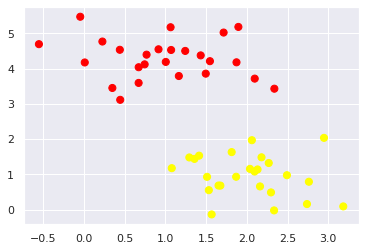

In [10]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');
plt.show()

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes.

We can draw them as follows:

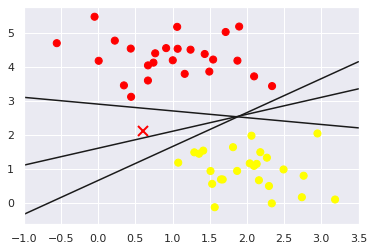

In [11]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label.
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## **Maximizing the Margin**

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point in the dataset!.


Here is an example of how this might look:

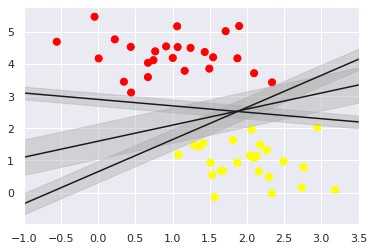

In [12]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For now, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [13]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [14]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape) # decision_function return the distance between the given points and the decision boundary

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5, # -1, 1 - Margins / 0 - decision boundaary
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=50, linewidth=1, facecolors='none', edgecolors='b');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

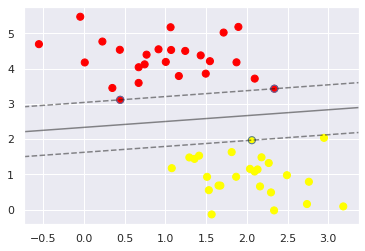

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black edges around the datapoint in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

Coordinates of the support vectors

In [16]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter. Any points further from the margin which are on the correct side do not modify the fit.
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

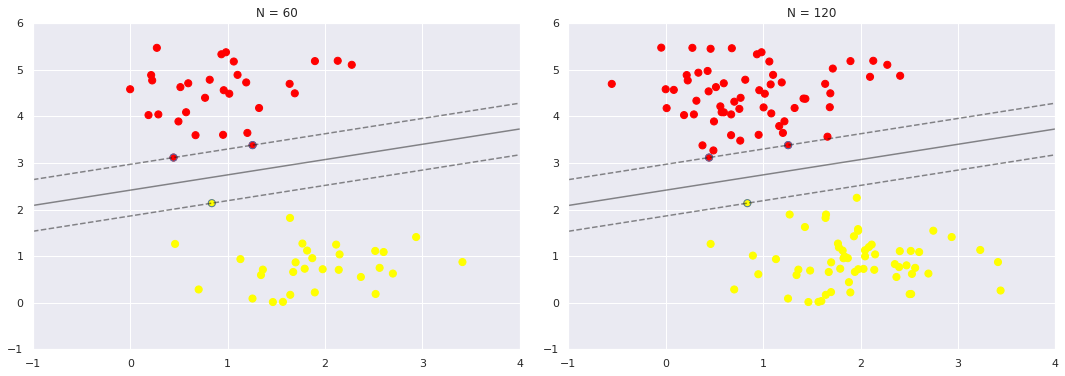

In [17]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

## *Question 1*

Observe the above figures, Why is the support vectors same for 60 and 120 data points? What would cause the support vectors to change in the 120 data points?

In [19]:
# TODO
svm_q1_answer = 'more support vectors (or) introduction of points in the margin/ wrongly classified points'

In [20]:
grader.grade(test_case_id = 'test_case_svm_q1', answer = svm_q1_answer)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


If you are running this worksheet live, you can also use IPython's interactive widgets to view this feature of the SVM model interactively:

In [21]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 200), value=10), Output()), _dom_classes…

## **Kernel SVM**

Where SVM becomes extremely powerful is when it is combined with *kernels*.
In linear regressions, kernels are used to project data into higher-dimensional space defined by polynomials and Gaussian basis functions, allowing us to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

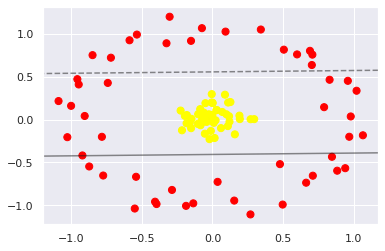

In [22]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1) # Coordinates, labesl

# Trying to fit a linear SVM to this dataset
clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [23]:
# Radial Basis Function
r = np.exp(-(X ** 2).sum(1))

In detail we are applying radial basis function to the 2D dataset and therefore projecting to 3D space (The new dimension would be r). Where now the datapoints would be linearly seperable.

We can visualize this extra data dimension using a three-dimensional plot—if you are running this worksheet live, you will be able to use the sliders to rotate the plot:

In [24]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection. If we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. (Just the normal Radial Basis function worked for the above case since the yellow dataset was clustered around the origin, while the red datapoints were not.)

In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly without ever building the full $N$-dimensional representation of the kernel projection.
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [25]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

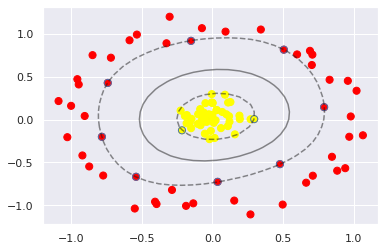

In [26]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

## **Softening Margins**

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

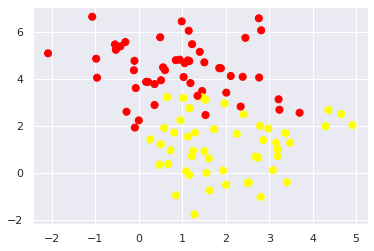

In [27]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

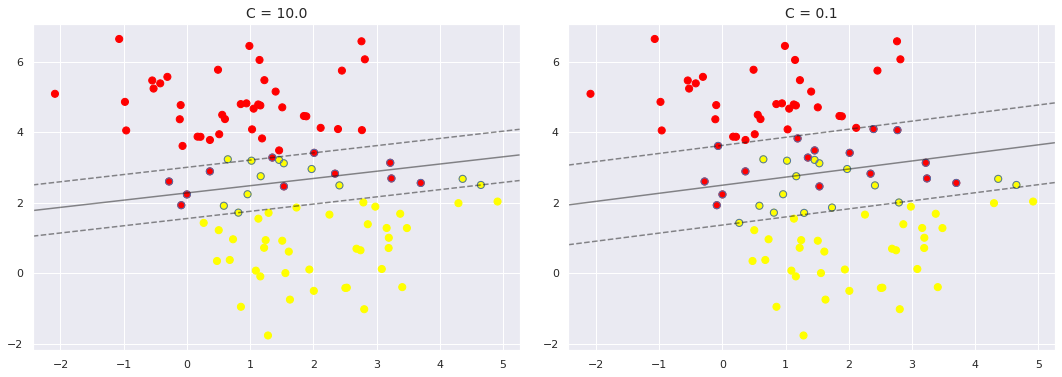

In [28]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).

## *Question 2*

Please illustrate in what scenario you will choose a relatively large `C` and explain the reason. Similarly, how about a relatively small `C`?

In [29]:
# TODO
svm_q2_answer = 'Larger C leads to softer margins. We choose large C when we care about classifying all instances of a feature correctly despite its location. We use a small c when it is more important to identify a linear margin between the two features'

In [30]:
grader.grade(test_case_id = 'test_case_svm_q2', answer = svm_q2_answer)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **Example: Face Recognition**

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [31]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

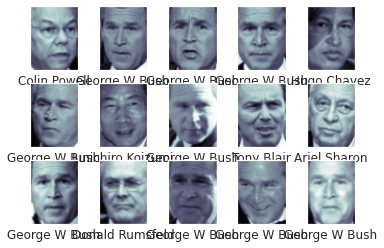

In [32]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [33]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [34]:
from sklearn.model_selection  import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [35]:
from sklearn.model_selection  import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 47.8 s, sys: 16.6 s, total: 1min 4s
Wall time: 35 s
{'svc__C': 10, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid. If they were at the edges, we would expand the grid to ensure we found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [36]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

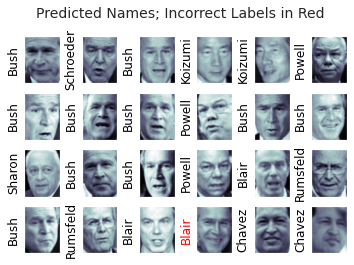

In [37]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [38]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:

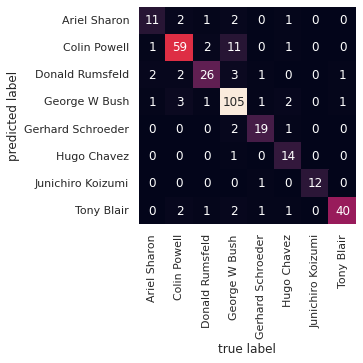

In [39]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## **Summary**

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With this in mind, you should only turn to SVMs once simpler, faster, and less tuning-intensive methods have been shown to be insufficient.
However, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

## Submitting to the Autograder

First of all, please run your notebook from beginning to end and ensure you are getting all the points from the autograder!

Now go to the File menu and choose "Download .ipynb".  Go to [Gradescope](https://www.gradescope.com/courses/409970) and:

1. From "File" --> Download both .ipynb and .py files
1. Name these files `SVM_WS.ipynb` and `SVM_WS.py` respectively
1. Sign in using your Penn email address (if you are a SEAS student we recommend using the Google login) and ensure  your class is "CIS 5200"
1. Select **Worksheet: SVM**
1. Upload both files
1. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY!

You should be set! Note that this assignment has 10 autograded points that will show up upon submission. Points are awarded based on a combination of correctness and sufficient effort. 